# Deep Unet
### Import packet 

In [1]:
pip install --upgrade install tensorflow==2.0.0.

     |████████████████████████████████| 86.3 MB 34 kB/s 
     |████████████████████████████████| 50 kB 3.3 MB/s 
     |████████████████████████████████| 3.8 MB 33.7 MB/s 
     |████████████████████████████████| 449 kB 9.2 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=5f26939aa4025132c2870ca6f47de2f3061680998f645e72bfc02905bca27591
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successf

In [2]:
pip install --upgrade install keras==2.3.0.

     |████████████████████████████████| 377 kB 8.0 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.7.0
    Uninstalling keras-2.7.0:
      Successfully uninstalled keras-2.7.0


In [3]:
!git clone https://github.com/yesidfonseca/VideoCompression.git DeepPriorCS

Cloning into 'DeepPriorCS'...
remote: Enumerating objects: 126, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 126 (delta 2), reused 6 (delta 2), pack-reused 120
Receiving objects: 100% (126/126), 11.43 MiB | 15.77 MiB/s, done.
Resolving deltas: 100% (72/72), done.


In [4]:
cd /content/DeepPriorCS

/content/DeepPriorCS


In [5]:
from MAIN import *  # donde esta el modelo y las funciones necesarias como psnr y demas 
from scipy.sparse import csr_matrix, find
print(tf.__version__)

from tensorflow.keras.preprocessing.image import ImageDataGenerator



Using TensorFlow backend.


2.0.0


In [6]:
def Hxfunction(x,largo,ancho,profun,H,Scale2D=0):
    Aux = tf.reshape(x,(largo,ancho,profun))    
    Aux = tf.math.multiply(Aux,H)
    #Aux = tf.math.reduce_sum(Aux,axis=2)    
    Aux = tf.reshape(Aux,(1,largo,ancho,profun))
    return Aux

def residualNet(pretrained_weights = None,input_size = (256,256,1), H=0,Scale2D = 0, shape_compressed = (256,256,10),Nbits = 8,MaxValue = 1, MinValue = -1):
    
    inputs = Input(input_size)
    inicial = XoLayer(shape_original = input_size, shape_compressed = shape_compressed,Nbits=Nbits,MaxValue = MaxValue, MinValue =MinValue )(inputs)
    
    #drop1 = Dropout(0.1)(inicial)
    #conv1 = Conv2D(L,1,activation=None,use_bias=True,padding='same',kernel_initializer='he_normal')(inicial)
    #conv1 = Conv2D(L,3,activation='relu',use_bias=True,padding='same',kernel_initializer='he_normal')(conv1)
    
    
    #conv8 = Conv2D(L,1,activation=None,use_bias=True,padding='same',kernel_initializer='he_normal')(conv1)
    #conv8 = Conv2D(L,3,activation='relu',use_bias=True,padding='same',kernel_initializer='he_normal')(conv8)
    
    
    #conv8 = Add()([conv8,conv1])
    
    final =Lambda(lambda x: Hxfunction(x,largo=input_size[0],ancho=input_size[1],profun = input_size[2],H=H,Scale2D=Scale2D)) (inicial)
    
    model = Model(input = inputs, output = final)

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

def tuckerDecomposition(InputTensor = 0, rhoXY = 0, rhoZ=0):
  temp = InputTensor
  [m,n,l] = temp.shape
  u, s, vh = np.linalg.svd(np.mean(temp,axis=2),full_matrices=True)
  rX = np.ceil(m*rhoXY).astype('int32')
  rY = np.ceil(n*rhoXY).astype('int32')
  rZ = np.ceil(l*rhoZ).astype('int32')
  #plt.plot(s[0:np.max([rX,rY])])
  u_ = u[:,0:rX]
  vh_ = vh[0:rY,:]
  Dx = u_
  Dy = vh_
  #fig = plt.figure()
  #fig.set_size_inches(8,8)
  
  pinvu_ =np.linalg.pinv(u_)
  pinvvh_ = np.linalg.pinv(vh_)
  kernelXY = np.zeros(shape=(rX,rY,l))
  reconstXY = temp*0
  for i in range(l):
    temp2 = temp[:,:,i]
    kernelXY[:,:,i] = np.matmul(pinvu_,np.matmul(temp2,pinvvh_))
    reconstXY[:,:,i] = np.matmul(Dx,np.matmul(kernelXY[:,:,i],Dy))
    
  #print(fun_PSNR(temp,reconstXY))

  kernelXYZ = np.reshape(kernelXY,(rX*rY,l),order='F')
  u2, s2, vh2 = np.linalg.svd(kernelXYZ,full_matrices=True)
  Dz = vh2[0:rZ,:]

  
  kernelXYZ = np.matmul(u2[:,0:rZ],np.diag(s2[0:rZ]))
  if rZ>len(s2):
    t = np.zeros((kernelXYZ.shape[0],rZ))
    t[0:len(s2),0:len(s2)] = u2 @ np.diag(s2)
    kernelXYZ = t
  
  

  reconst_kernelXY = np.matmul(kernelXYZ,Dz)

  reconst_kernelXY = np.reshape(reconst_kernelXY,(rX,rY,l),order='F')

  reconstXYZ = temp*0
  for i in range(l):
    reconstXYZ[:,:,i] = np.matmul(Dx,np.matmul(reconst_kernelXY[:,:,i],Dy))

  

  #ErrBest = np.divide(np.power(np.sum(np.power(reconstXYZ-temp,2),axis=2),0.5),np.power(np.sum(np.power(temp,2),axis=2),0.5))
  #plt.imshow(ErrBest, cmap='hot', vmin=0, vmax=1)
  return kernelXYZ, Dx, Dy, Dz, reconstXY, reconstXYZ

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


[ 5600  7013  6042 20393 10239  7715  3127  5407]


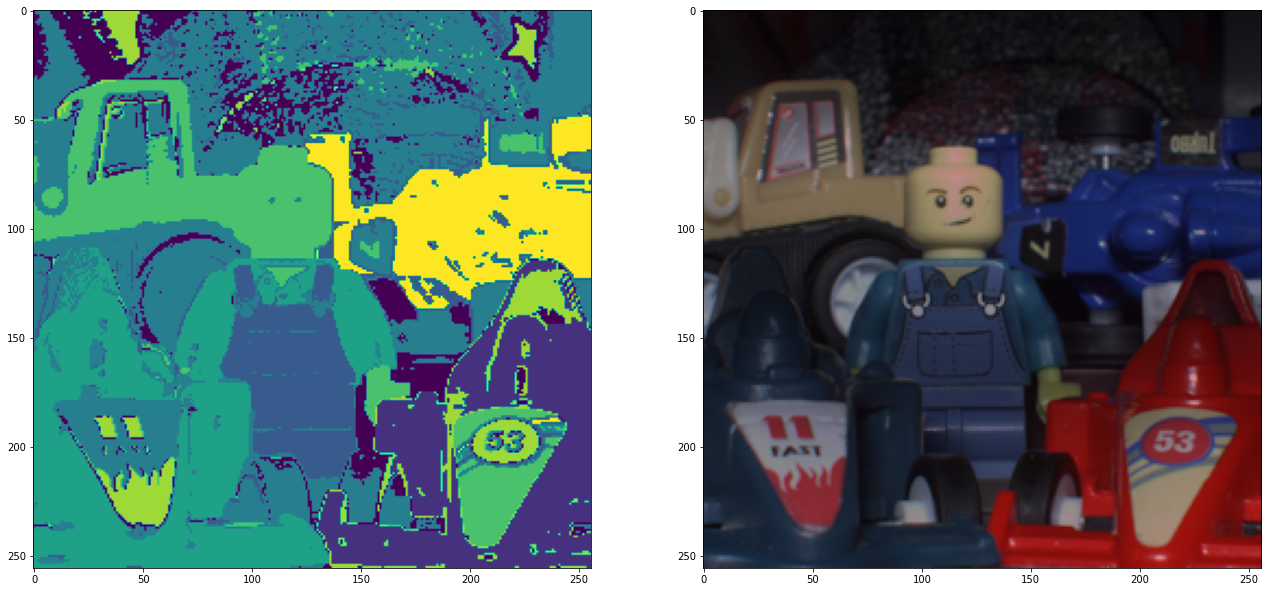

In [18]:
# Load Data
Mat= scipy.io.loadmat('LegoCars.mat')
testSI=np.double(Mat['hyperimg'])
testSI = testSI[0:256,0:256,:];
testSI=((testSI-np.min(testSI))/(np.max(testSI)-np.min(testSI)))
testSI = tf.constant(testSI,dtype='float32',shape=testSI.shape)
testSI = tf.quantization.fake_quant_with_min_max_args(testSI, min=0, max=1, num_bits=8, narrow_range=False, name=None)
testSI = testSI.numpy()
ColorBands = [8,4,2]
RGB = testSI[:,:,ColorBands]
[m,n,l]=testSI.shape


from sklearn.cluster import KMeans
#Fixing random seed 
import random
tf.random.set_seed(1)
random.seed(1)
n_cluster_kmeans = 8;
n_cluster_linearseg = 1;

X = np.reshape(testSI,(m*n,l),order='F')
#xv, yv = np.meshgrid(np.linspace(0,m-1,m).astype('int32'), np.linspace(0,n-1,n).astype('int32'), sparse=False, indexing='ij')
#spacialFeatures = np.concatenate((.2+np.reshape(xv,(m*n,1))/m/2,.2+np.reshape(yv,(m*n,1))/n/2),axis=1)
#X = np.concatenate((X,spacialFeatures),axis=1)
length = np.sqrt((X**2).sum(axis=1))[:,None]
X = X / length
kmeans = KMeans(n_clusters=n_cluster_kmeans, random_state=0).fit(X)
labels = kmeans.labels_

import skimage.segmentation as seg
image_slic = seg.slic(testSI[:,:,:],n_segments=n_cluster_linearseg)
labels2d = np.reshape(labels,(m,n),order='F')
newlabes2d = np.zeros((m,n),dtype='uint8')
for i in range(n_cluster_linearseg):
  for j in range(n_cluster_kmeans):
    newlabes2d = newlabes2d + ((image_slic==i)*(labels2d==j)).astype('uint8')*(i*n_cluster_kmeans+j)
labels = newlabes2d.flatten('F')

fig, axs = plt.subplots(1,2,figsize=(22,22))
axs[0].imshow(np.reshape(labels,(m,n),order='F'))
axs[1].imshow(testSI[:,:,ColorBands])
LabelNames, counts = np.unique(labels, return_counts=True)
print(counts)

mdic = {"labels": np.reshape(labels,(m,n),order='F').astype('uint8')}
scipy.io.savemat("testlabels.mat", mdic,do_compression=True)


In [8]:
def getHMatrixByClusterLabel(labels,LabelName,m,n,l,testSI):
  labels2d = np.reshape(labels,(m,n),order='F')
  H_s = np.ones(dtype='float32',shape=(m,n,l))
  for i in range(m):
      for j in range(n):
            if labels2d[i,j] != LabelName:    
              H_s[i,j,:] = H_s[i,j,:]*0  

  H_s = tf.constant(H_s,dtype='float32')
  x_ = tf.constant(testSI,dtype='float32')
  y = Hxfunction(x_,largo=m,ancho=n,profun=l,H=H_s,Scale2D=0)
  y = np.double(y.numpy())
  plt.imshow(y[:,:,:,0].reshape((m,n),order="F")/np.max(y))
  return H_s, y
 
#def getReducedImageByClusterLabel(labels,LabelName,m,n,l,testSI):
#labels2d = np.reshape(labels,(m,n),order='F')


In [ ]:
#Reconstruction Parameters setup
rhoXY = 0.05
rhoZ = 0.3
learning_rate = 1e-2
iters = 1500
Nbits = [10,8]



#Visualization Parameters setup
Freq = 50

optimizad = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.9,epsilon=1e-07, amsgrad=True);
#optimizad = tf.keras.optimizers.SGD(learning_rate=learning_rate, nesterov=True);


MaxValue = 1
MinValue = -1
FinalReconstruction = testSI*0
#Optimization
for labelname in LabelNames:
  H_s, y = getHMatrixByClusterLabel(labels,labelname,m,n,l,testSI)
  

  for stage1 in range(len(Nbits)):
  
  
    model = residualNet(input_size = (m,n,l), L=l,H=H_s, factXY= rhoXY,factZ = rhoZ,Nbits = Nbits[stage1], MaxValue =MaxValue , MinValue =MinValue )#Scale2D = Scale2D
    model.compile(optimizer=optimizad, loss='mean_squared_error')
    if stage1>0:
      model.set_weights(Ws)
    else:
      kernel, Dx, Dy, Dz, reconstXY, reconstXYZ = tuckerDecomposition(InputTensor = testSI, rhoXY = rhoXY, rhoZ=rhoZ)
      maxValue = 1
      if np.abs(Dx).max() >1:
        maxValue = maxValue*np.abs(Dx).max()
        Dx = Dx/np.abs(Dx).max()
      if np.abs(Dy).max() >1:
        maxValue = maxValue*np.abs(Dy).max()
        Dy = Dy/np.abs(Dy).max()
      if np.abs(Dz).max() >1:
        maxValue = maxValue*np.abs(Dz).max()
        Dz = Dz/np.abs(Dz).max()
      if np.abs(kernel).max() >1:
        maxValue = maxValue*np.abs(kernel).max()
        kernel = kernel/np.abs(kernel).max()
      
      Ws = model.get_weights() 
      Ws2 = [kernel, Dx,Dy,Dz]
      for i in range(4):  
        Ws[i] = Ws2[i]
      model.set_weights(Ws)
    





    model.fit(np.zeros(shape=(1,m,n,l)), y, epochs = iters,batch_size=1,callbacks=[myCallback(np.reshape(y,(m,n,l)),Freq,[8,4,2],BestPSNR = 0, Best = testSI*0,Nbits=Nbits[stage1])],verbose=0)


    #Best Result
    BestResult = model.Best
    BestPSNR = model.BestPSNR
    BestWeights = model.BestWeights

    Ws = BestWeights #model.get_weights()
    NewMaxValue = -2**20
    NewMinValue = 2**20
    for i in range(4):
      Ws_ = tf.constant(Ws[i],dtype='float32',shape=Ws[i].shape)
      #Ws_ = ((Ws_-MinValue)/(MaxValue-MinValue))*((2**Nbits)-1);
      #Ws_ = tf.cast(Ws_,dtype='uint8')
      Ws_ = tf.quantization.fake_quant_with_min_max_args(Ws_, min=MinValue, max=MaxValue, num_bits=Nbits[stage1], narrow_range=False, name=None)
      #TuckerWeights.append(Ws_)    
      #Ws_ = ((Ws_/255)*2)-1
      Ws[i] = Ws_.numpy()
      NewMaxValue = np.max([NewMaxValue, np.amax(Ws[i])])
      NewMinValue = np.min([NewMinValue, np.amin(Ws[i])])
    
    if stage1<len(Nbits)-1:
      MaxValue = NewMaxValue
      MinValue = NewMinValue
    print('Nbits %05d: MaxValue %6.3f : MinValue %6.3f' % (Nbits[stage1], MaxValue,MinValue))
  

  
  Ws = BestWeights
  TuckerWeights = []
  for i in range(4):
    Ws_ = tf.constant(Ws[i],dtype='float32',shape=Ws[i].shape)
    Ws_ = ((Ws_-MinValue)/(MaxValue-MinValue))*255;
    Ws_ = tf.cast(Ws_,dtype='uint8')
    TuckerWeights.append(Ws_.numpy())
  TuckerWeights.append(MaxValue.astype('float32'))
  TuckerWeights.append(MinValue.astype('float32'))
  
  FinalReconstruction = FinalReconstruction + BestResult
  mdic = {"kernel": TuckerWeights[0],"dx":TuckerWeights[1],"dy":TuckerWeights[2],"dz":TuckerWeights[3], "MaxValue":TuckerWeights[4],"MinValue":TuckerWeights[5]}
  scipy.io.savemat("test"+str(labelname)+".mat", mdic,do_compression=True)


VisualGraphs(FinalReconstruction,FinalReconstruction,FinalReconstruction,model.PSNRs,testSI,ColorBands)  
print(fun_PSNR(testSI,FinalReconstruction))  




    


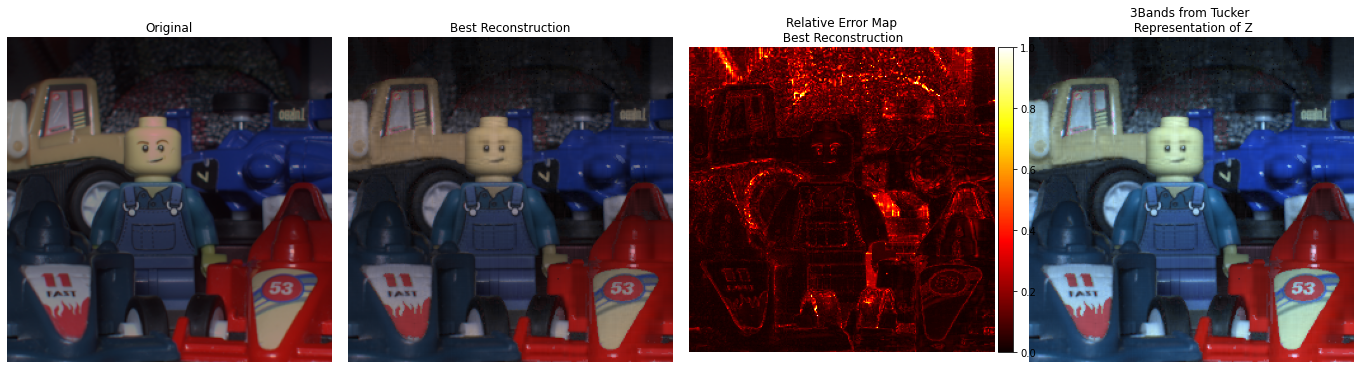

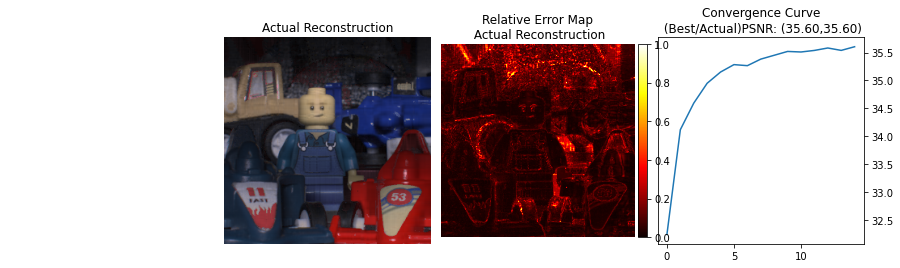

36.3484001159668


In [35]:
#Reconstruction Parameters setup
rhoXY = 0.05
rhoZ = 0.3
learning_rate = 1e-2
iters = 750
Nbits = [10,8]



#Visualization Parameters setup
Freq = 50

optimizad = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.9,epsilon=1e-07, amsgrad=True);
#optimizad = tf.keras.optimizers.SGD(learning_rate=learning_rate, nesterov=True);

AllSizes = [];
VectorizedData = [];
MinMaxValues =[];

FinalReconstruction = testSI*0
#Optimization
for labelname in LabelNames:
  MaxValue = 1
  MinValue = -1
  
  
  H_s, testSI_patch = GetPatchANDHsMatrixByClusterLabel(labels,labelname,m,n,l,testSI)
  [m_,n_,l_] = testSI_patch.shape
  y_ = np.reshape(testSI_patch,(1,m_,n_,l_))

  rhoXY = 0.01
  kernel, Dx, Dy, Dz, reconstXY, reconstXYZ = tuckerDecomposition(InputTensor = testSI_patch, rhoXY = rhoXY, rhoZ=rhoZ)
  tuckerDPSNR = fun_PSNR(np.multiply(testSI_patch,H_s.numpy()), np.multiply(reconstXYZ,H_s.numpy()))
  idx = np.sum(np.abs(np.multiply(reconstXYZ,H_s.numpy())),axis=2)>0    
  for i in range(20):
    if(np.sum(labels==labelname)<=np.sum(idx.flatten('F')))*(tuckerDPSNR>26):
      break
    rhoXY = rhoXY+0.01
    kernel, Dx, Dy, Dz, reconstXY, reconstXYZ = tuckerDecomposition(InputTensor = testSI_patch, rhoXY = rhoXY, rhoZ=rhoZ)
    tuckerDPSNR = fun_PSNR(np.multiply(testSI_patch,H_s.numpy()), np.multiply(reconstXYZ,H_s.numpy()))
  #print(tuckerDPSNR)

  for stage1 in range(len(Nbits)):
  
    shape_compressed = (Dx.shape[1],Dy.shape[0],Dz.shape[0])
    model = residualNet(input_size = testSI_patch.shape,H=H_s,shape_compressed = shape_compressed ,Nbits = Nbits[stage1], MaxValue =MaxValue , MinValue =MinValue )#Scale2D = Scale2D
    model.compile(optimizer=optimizad, loss='mean_squared_error')
    if stage1>0:
      model.set_weights(Ws)
    else:
      kernel, Dx, Dy, Dz, reconstXY, reconstXYZ = tuckerDecomposition(InputTensor = testSI_patch, rhoXY = rhoXY, rhoZ=rhoZ)
      maxValue = 1
      if np.abs(Dx).max() >1:
        maxValue = maxValue*np.abs(Dx).max()
        Dx = Dx/np.abs(Dx).max()
      if np.abs(Dy).max() >1:
        maxValue = maxValue*np.abs(Dy).max()
        Dy = Dy/np.abs(Dy).max()
      if np.abs(Dz).max() >1:
        maxValue = maxValue*np.abs(Dz).max()
        Dz = Dz/np.abs(Dz).max()
      if np.abs(kernel).max() >1:
        maxValue = maxValue*np.abs(kernel).max()
        kernel = kernel/np.abs(kernel).max()
      
      Ws = model.get_weights() 
      Ws2 = [kernel, Dx,Dy,Dz]
      for i in range(4):  
        Ws[i] = Ws2[i]
      model.set_weights(Ws)
    





    model.fit(np.zeros(shape=(1,m_,n_,l_)), y_, epochs = iters,batch_size=1,callbacks=[myCallback(testSI_patch,Freq,ColorBands,BestPSNR = 0, Best = testSI_patch*0,Nbits=Nbits[stage1])],verbose=0)


    #Best Result
    BestResult = model.Best
    BestPSNR = model.BestPSNR
    BestWeights = model.BestWeights

    Ws = BestWeights #model.get_weights()
    NewMaxValue = -2**20
    NewMinValue = 2**20
    for i in range(4):
      Ws_ = tf.constant(Ws[i],dtype='float32',shape=Ws[i].shape)
      #Ws_ = ((Ws_-MinValue)/(MaxValue-MinValue))*((2**Nbits)-1);
      #Ws_ = tf.cast(Ws_,dtype='uint8')
      Ws_ = tf.quantization.fake_quant_with_min_max_args(Ws_, min=MinValue, max=MaxValue, num_bits=Nbits[stage1], narrow_range=False, name=None)
      #TuckerWeights.append(Ws_)    
      #Ws_ = ((Ws_/255)*2)-1
      Ws[i] = Ws_.numpy()
      NewMaxValue = np.max([NewMaxValue, np.amax(Ws[i])])
      NewMinValue = np.min([NewMinValue, np.amin(Ws[i])])
    
    if stage1<len(Nbits)-1:
      MaxValue = NewMaxValue
      MinValue = NewMinValue
    print('Nbits %05d: MaxValue %6.3f : MinValue %6.3f' % (Nbits[stage1], MaxValue,MinValue))
  

  
  Ws = BestWeights
  TuckerWeights = []  
  for i in range(4):
    Ws_ = tf.constant(Ws[i],dtype='float32',shape=Ws[i].shape)
    Ws_ = ((Ws_-MinValue)/(MaxValue-MinValue))*255;
    Ws_ = tf.cast(Ws_,dtype='uint8')
    TuckerWeights.append(Ws_.numpy())
    AllSizes.append([Ws_.numpy().shape[0],Ws_.numpy().shape[1]])
    VectorizedData  = np.concatenate((VectorizedData,Ws_.numpy().flatten('F')))

  MinMaxValues.append([MinValue, MaxValue])

  TuckerWeights.append(MaxValue.astype('float32'))
  TuckerWeights.append(MinValue.astype('float32'))
  
  reconst_BestResult = InvGetPatchANDHsMatrixByClusterLabel(labels,labelname,m,n,l,BestResult)  
  FinalReconstruction = FinalReconstruction + reconst_BestResult
  #mdic = {"kernel": TuckerWeights[0],"dx":TuckerWeights[1],"dy":TuckerWeights[2],"dz":TuckerWeights[3], "MaxValue":TuckerWeights[4],"MinValue":TuckerWeights[5]}
  #scipy.io.savemat("test"+str(labelname)+".mat", mdic,do_compression=True)

  mdic = {"AllSizes": np.array(AllSizes), "VectorizedData":VectorizedData.astype('uint8'), "MinMaxValues": np.array(MinMaxValues)}
  scipy.io.savemat("testfinal.mat", mdic,do_compression=True)

VisualGraphs(FinalReconstruction,FinalReconstruction,FinalReconstruction,model.PSNRs,testSI,ColorBands)  
print(fun_PSNR(testSI,FinalReconstruction))  



In [ ]:
from scipy.sparse import diags, coo_matrix, block_diag
#H_t = np.hstack((((np.random.rand(m,n)<0.1)).astype('float32'),np.zeros(shape = (m,l-1),dtype='float32')))
#H_t = np.tile(np.tile(np.array([[1,1,1,1,0,0,1,1,1,1],[0,0,0,1,0,0,1,0,0,0],[0,1,1,1,0,0,1,1,1,0],[0,1,0,0,0,0,0,0,1,0],[0,1,1,1,1,1,1,1,1,0],[0,0,0,0,1,0,0,1,0,0],[1,1,1,0,1,0,0,1,0,0],[1,0,1,0,1,1,1,1,1,1],[1,0,1,1,1,0,0,1,0,0],[1,0,0,0,0,0,0,1,0,0]]),100).transpose(),100)
H_t = np.tile(np.tile(np.array((np.random.rand(20,20)<0.9).astype('float32')),100).transpose(),100)
H_t = np.hstack(((H_t[0:m,0:n]).astype('float32'),np.zeros(shape = (m,l-1),dtype='float32')))
#H_t = y[:,:,:,:].reshape((m,n),order="F")/np.max(y)
#print(H_t.flatten('F'))
#print(H_t)
D_t = H_t.flatten('F')
H_t = diags(D_t,shape=(D_t.shape[0], D_t.shape[0]))
(I,J,V) = find(H_t)
H = csr_matrix((V, (I, J)), shape=(m*(n+l-1), m*n)) 
for i in range(l-1):
  I = I+m;
  H_t = csr_matrix((V, (I, J)), shape=(m*(n+l-1), m*n))
  H = block_diag((H,H_t))

(I,J,V) = find(H)
H_s = tf.SparseTensor(indices = np.transpose(np.asarray([I,J]),(1,0)), values = V, dense_shape=[H.shape[0], H.shape[1]])

def Hxfunction(x,largo,ancho,profun,H,Scale2D):
    Aux = tf.reshape(x,(largo,ancho,profun))
    Aux = tf.transpose(Aux,perm=[2,1,0])
    Aux = tf.reshape(Aux,(largo*ancho*profun,1))

    Aux = tf.sparse.sparse_dense_matmul(H,Aux) 
    
    Aux = tf.reshape(Aux,(profun,ancho+profun-1,largo))
    Aux = tf.transpose(Aux,perm=[2,1,0])
    Aux = tf.reduce_sum(Aux,axis=2)
    Aux = tf.reshape(Aux,(1,largo,ancho+profun-1))
    Aux = tf.math.multiply(Aux,Scale2D)
    return Aux


Scale2D = Hxfunction(tf.constant(1,dtype='float32',shape = (m,n,l)),largo=m,ancho=n,profun=l,H=H_s,Scale2D = tf.constant(1,dtype='float32',shape = (1,m,n+l-1)))
Scale2D = 1/(Scale2D+1)

x_ = tf.constant(testSI,dtype='float32')
y = Hxfunction(x_,largo=m,ancho=n,profun=l,H=H_s,Scale2D = Scale2D)
y = np.double(y.numpy())
plt.imshow(y.reshape((m,n+l-1),order="F")/np.max(y))

In [ ]:
import sys
sys.getsizeof(testSI.astype('float32'))
model.count_params()/(m*n*l)

In [ ]:
H_s = tf.constant(1,dtype='float32',shape=(m,n,l))
x_ = tf.constant(testSI,dtype='float32')
y = Hxfunction(x_,largo=m,ancho=n,profun=l,H=H_s,Scale2D=0)
y = np.double(y.numpy())
plt.imshow(y[:,:,:,0].reshape((m,n),order="F")/np.max(y))

In [ ]:
func = K.function([model.layers[0].input],[model.layers[1].output])
xo = func(np.zeros(shape=(m,n,l)))
xo = np.asarray(xo).reshape((m,n,l),order="F")
xo.min()

In [ ]:
Ws = model.get_weights()
TuckerWeights = []
for i in range(4):
  Ws_ = tf.constant(Ws[i],dtype='float32',shape=Ws[i].shape)
  Ws_ = ((Ws_+1)/2)*255;
  Ws_ = tf.cast(Ws_,dtype='uint8')
  TuckerWeights.append(Ws_)
  Ws_ = tf.cast(Ws_,dtype='float32')
  Ws_ = ((Ws_/255)*2)-1
  Ws[i] = Ws_.numpy()


model2 = model
model2.set_weights(Ws)
func = K.function([model2.layers[0].input],[model2.layers[len(model2.layers)-2].output])
FinalResult = func(np.zeros(shape=(m,n,l)))
FinalResult = np.asarray(FinalResult).reshape((m,n,l),order="F")
PSNR_Final = fun_PSNR(testSI,FinalResult)
VisualGraphs(FinalResult,BestResult,ZTuckerRepr,PSNRs,testSI,[8,4,2])
PSNR_Final



In [ ]:
mdic = {"kernel": np.reshape(TuckerWeights[0].numpy(),(3,77,77)).transpose((1,2,0)),"dx":TuckerWeights[1].numpy(),"dy":TuckerWeights[2].numpy(),"dz":TuckerWeights[3].numpy()}
scipy.io.savemat("test.mat", mdic,do_compression=True)
TuckerWeights[3]
model.count_params()-77*77*3-256*77*2-30
np.min(Ws[11])

In [ ]:
#dir(model.layers[1])
#model.layers[1].non_trainable_weights
(model.count_params()-model.layers[1].count_params())*32/8
(model.count_params()-model.layers[1].count_params())*4+model.layers[1].count_params()
#model.layers[3].get_weights()[0].shape #.count_params()
for i in range(2):
  print(i)

In [ ]:
def tuckerDecomposition(InputTensor = 0, rhoXY = 0, rhoZ=0):
  temp = InputTensor
  u, s, vh = np.linalg.svd(temp[:,:,np.round(l*0.5).astype('int32')])
  rX = np.round(m*rhoXY).astype('int32')
  rY = np.round(n*rhoXY).astype('int32')
  rZ = np.round(l*rhoZ).astype('int32')
  plt.plot(s[0:np.max([rX,rY])])
  u_ = u[:,0:rX]
  vh_ = vh[0:rY,:]
  Dx = u_
  Dy = vh_
  fig = plt.figure()
  fig.set_size_inches(8,8)
  
  pinvu_ =np.linalg.pinv(u_)
  pinvvh_ = np.linalg.pinv(vh_)
  kernelXY = np.zeros(shape=(rX,rY,l))
  reconstXY = temp*0
  for i in range(10):
    temp2 = temp[:,:,i]
    kernelXY[:,:,i] = np.matmul(pinvu_,np.matmul(temp2,pinvvh_))
    reconstXY[:,:,i] = np.matmul(Dx,np.matmul(kernelXY[:,:,i],Dy))
    
  print(fun_PSNR(temp,reconstXY))

  kernelXYZ = np.reshape(kernelXY,(rX*rY,l),order='F')
  u2, s2, vh2 = np.linalg.svd(kernelXYZ)
  Dz = vh2[0:rZ,:]

  kernelXYZ = np.matmul(u2[:,0:rZ],np.diag(s2[0:rZ]))

  reconst_kernelXY = np.matmul(kernelXYZ,Dz)

  reconst_kernelXY = np.reshape(reconst_kernelXY,(rX,rY,l),order='F')

  reconstXYZ = temp*0
  for i in range(l):
    reconstXYZ[:,:,i] = np.matmul(Dx,np.matmul(reconst_kernelXY[:,:,i],Dy))

  print(fun_PSNR(temp,reconstXYZ))

  ErrBest = np.divide(np.power(np.sum(np.power(reconstXYZ-temp,2),axis=2),0.5),np.power(np.sum(np.power(temp,2),axis=2),0.5))
  plt.imshow(ErrBest, cmap='hot', vmin=0, vmax=1)
  return kernelXYZ, Dx, Dy, Dz, reconstXY, reconstXYZ

In [ ]:
kernel, Dx, Dy, Dz, reconstXY, reconstXYZ = tuckerDecomposition(InputTensor = testSI, rhoXY = rhoXY, rhoZ=rhoZ)
maxValue = 1
if np.abs(Dx).max() >1:
  maxValue = maxValue*np.abs(Dx).max()
  Dx = Dx/np.abs(Dx).max()
if np.abs(Dy).max() >1:
  maxValue = maxValue*np.abs(Dy).max()
  Dy = Dy/np.abs(Dy).max()
if np.abs(Dz).max() >1:
  maxValue = maxValue*np.abs(Dz).max()
  Dz = Dz/np.abs(Dz).max()
if np.abs(kernel).max() >1:
  maxValue = maxValue*np.abs(kernel).max()
  kernel = kernel/np.abs(kernel).max()

model = residualNet(input_size = (m,n,l), L=l,H=H_s, factXY= rhoXY,factZ = rhoZ,Nbits = 16, MaxValue =1 , MinValue =-1 )#Scale2D = Scale2D

In [ ]:
Ws = model.get_weights() 
for i in range(4): 
  print(Ws[i].shape)
Ws2 = [kernel, Dx,Dy,Dz]
Ws_ = Ws
for i in range(4):  
  Ws_[i] = Ws2[i]
  print(Ws_[i].shape)
  print(Ws[i].shape)


model.set_weights(Ws)
func = K.function([model.layers[0].input],[model.layers[1].output])
xo = func(np.zeros(shape=(m,n,l)))
xo = np.asarray(xo).reshape((m,n,l))
plt.imshow(xo[:,:,9])
print(fun_PSNR(reconstXYZ,xo*maxValue))

In [ ]:
pip install scikit-image

In [ ]:
import skimage.segmentation as seg
image_slic = seg.slic(testSI[:,:,:],n_segments=8)
plt.imshow(image_slic)
labels2d = np.reshape(labels,(m,n),order='F')
newlabes2d = np.zeros((m,n),dtype='uint8')
for i in range(16):
  for j in range(8):
    newlabes2d = newlabes2d + ((image_slic==i)*(labels2d==j)).astype('uint8')*(i*8+j)
plt.imshow(newlabes2d)
LabelNames, counts = np.unique(newlabes2d, return_counts=True)

params_sum = 0;
for labelname in LabelNames:
  H_s, y = getHMatrixByClusterLabel(newlabes2d.flatten('F'),labelname,m,n,l,testSI)
  testSI_patch = testSI
  templabels2d = newlabes2d==labelname
  removedcols = np.sum(templabels2d.astype('int32'),axis=0)<1
  templabels2d = np.delete(templabels2d,removedcols,axis=1)
  testSI_patch = np.delete(testSI_patch,removedcols,axis=1)
  removedrows = np.sum(templabels2d.astype('int32'),axis=1)<1
  templabels2d = np.delete(templabels2d,removedrows,axis=0)
  testSI_patch = np.delete(testSI_patch,removedrows,axis=0)
  #print('shape %05d: ratio %6.3f ' % (templabels2d.shape, np.prod(templabels2d.shape)/(m*n*l)))

  reconst_temlabels2d = newlabes2d*0  
  reconst_testSI_patch = testSI*0
  notremovedcols = np.sum((newlabes2d==labelname).astype('int32'),axis=0)>0
  notremovedrows = np.sum((newlabes2d==labelname).astype('int32'),axis=1)>0
  k = 0;
  templabels2d_flatten = templabels2d.flatten('F')
  testSI_patch_flatten = np.reshape(testSI_patch,(np.prod(testSI_patch.shape[0:2]),testSI_patch.shape[2]),order='F')
  for j in range(n):
    for i in range(m):
      if(notremovedrows[i]):
        if(notremovedcols[j]):
          reconst_temlabels2d[i,j] = templabels2d_flatten[k]
          reconst_testSI_patch[i,j,:] = testSI_patch_flatten[k,:]
          k = k+1
  #print(np.divide(np.power(np.sum(np.power(reconst_temlabels2d.flatten('F')-(newlabes2d==labelname).flatten('F'),2),axis=0),0.5),np.power(np.sum(np.power((newlabes2d==labelname).flatten('F'),2),axis=0),0.5)))
  xx = np.multiply(testSI,H_s.numpy())
  yy = np.multiply(reconst_testSI_patch,H_s.numpy())
  print(np.divide(np.power(np.sum(np.power(xx.flatten('F')-yy.flatten('F'),2),axis=0),0.5),np.power(np.sum(np.power(xx.flatten('F'),2),axis=0),0.5)))
  



  #print(templabels2d.shape)
  m_ = np.ceil(templabels2d.shape[0]*0.05)
  n_ = np.ceil(templabels2d.shape[1]*0.05)
  l_ = 3
  params_sum = params_sum + m_*n_*l_ + l_*10+ m_*templabels2d.shape[0]+n_*templabels2d.shape[1]
  #plt.imshow(testSI_patch[:,:,ColorBands])
  plt.imshow(reconst_temlabels2d)







In [15]:
def GetPatchANDHsMatrixByClusterLabel(labels,labelname,m,n,l,testSI):
  labels2d = np.reshape(labels,(m,n),order='F')
  testSI_patch = testSI
  templabels2d = labels2d==labelname
  removedcols = np.sum(templabels2d.astype('int32'),axis=0)<1
  templabels2d = np.delete(templabels2d,removedcols,axis=1)
  testSI_patch = np.delete(testSI_patch,removedcols,axis=1)
  removedrows = np.sum(templabels2d.astype('int32'),axis=1)<1
  templabels2d = np.delete(templabels2d,removedrows,axis=0)
  testSI_patch = np.delete(testSI_patch,removedrows,axis=0)  
  
  H_s = np.dstack([templabels2d]*l).astype('float32')
  H_s = tf.constant(H_s,dtype='float32')
  testSI_patch = np.multiply(testSI_patch,H_s.numpy())

  return H_s, testSI_patch
  
def InvGetPatchANDHsMatrixByClusterLabel(labels,labelname,m,n,l,testSI_patch):
  labels2d = np.reshape(labels,(m,n),order='F')
  reconst_testSI_patch = np.zeros((m,n,l),dtype='float32',order='F')
  notremovedcols = np.sum((labels2d==labelname).astype('int32'),axis=0)>0
  notremovedrows = np.sum((labels2d==labelname).astype('int32'),axis=1)>0
  k = 0  
  testSI_patch_flatten = np.reshape(testSI_patch,(np.prod(testSI_patch.shape[0:2]),testSI_patch.shape[2]),order='F')
  for j in range(n):
    for i in range(m):
      if(notremovedrows[i]):
        if(notremovedcols[j]):          
          reconst_testSI_patch[i,j,:] = testSI_patch_flatten[k,:]
          k = k+1
  
  return reconst_testSI_patch

In [9]:
#version 2 para comprimir los patches en cubos
def GetPatchANDHsMatrixByClusterLabel(labels,labelname,m,n,l,testSI):
  labels2d = np.reshape(labels,(m,n),order='F')
  testSI_patch = testSI
  templabels2d = labels2d==labelname
  m_ = np.ceil(np.sqrt(np.sum(templabels2d.flatten('F')))).astype('int32')
  n_ = m_
  testSI_patch = np.zeros((m_*n_,l),dtype='float32')
  H_s = np.zeros((m_*n_,1),dtype='float32')
  k = 0
  #testSI_flatten = np.reshape(testSI,(m*n,l),order='F')
  for j in range(n):
    for i in range(m):      
      if(templabels2d[i,j]):
        testSI_patch[k,:] = testSI[i,j,:]
        H_s[k] = 1
        k= k+1
  testSI_patch = np.reshape(testSI_patch,(m_,n_,l),order='F')

  H_s = np.reshape(H_s,(m_,n_),order='F')
  H_s = np.dstack([H_s]*l).astype('float32')
  H_s = tf.constant(H_s,dtype='float32')
  testSI_patch = np.multiply(testSI_patch,H_s.numpy())

  return H_s, testSI_patch
  
def InvGetPatchANDHsMatrixByClusterLabel(labels,labelname,m,n,l,testSI_patch):
  labels2d = np.reshape(labels,(m,n),order='F')
  templabels2d = labels2d==labelname
  reconst_testSI_patch = np.zeros((m,n,l),dtype='float32',order='F')
  
  k = 0  
  testSI_patch_flatten = np.reshape(testSI_patch,(np.prod(testSI_patch.shape[0:2]),testSI_patch.shape[2]),order='F')
  for j in range(n):
    for i in range(m):
      if(templabels2d[i,j]):
        reconst_testSI_patch[i,j,:] = testSI_patch_flatten[k,:]
        k = k+1
  
  return reconst_testSI_patch

1541
1748
5088
12029
17578
4988
1334
2230


0.0846435546875

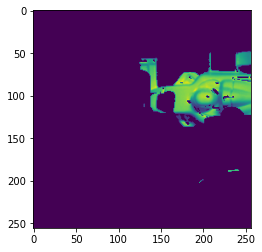

In [19]:
params_sum = 0;
for labelname in LabelNames:
  H_s, y = getHMatrixByClusterLabel(labels,labelname,m,n,l,testSI)
  H_s_patch, testSI_patch = GetPatchANDHsMatrixByClusterLabel(labels,labelname,m,n,l,testSI)
  

  reconst_testSI_patch = InvGetPatchANDHsMatrixByClusterLabel(labels,labelname,m,n,l,testSI_patch)  
  
  xx = np.multiply(testSI,H_s.numpy())
  yy = np.multiply(reconst_testSI_patch,H_s.numpy())
  #print(np.divide(np.power(np.sum(np.power(xx.flatten('F')-yy.flatten('F'),2),axis=0),0.5),np.power(np.sum(np.power(xx.flatten('F'),2),axis=0),0.5)))
  
  if (True):
    rhoXY = 0.01
    kernel, Dx, Dy, Dz, reconstXY, reconstXYZ = tuckerDecomposition(InputTensor = testSI_patch, rhoXY = rhoXY, rhoZ=0.3)
    tuckerDPSNR = fun_PSNR(np.multiply(testSI_patch,H_s_patch.numpy()), np.multiply(reconstXYZ,H_s_patch.numpy()))
    idx = np.sum(np.abs(np.multiply(reconstXYZ,H_s_patch.numpy())),axis=2)>0
    
    for i in range(20):
      if(np.sum(labels==labelname)<=np.sum(idx.flatten('F')))*(tuckerDPSNR>26):
        break
      rhoXY = rhoXY+0.01
      kernel, Dx, Dy, Dz, reconstXY, reconstXYZ = tuckerDecomposition(InputTensor = testSI_patch, rhoXY = rhoXY, rhoZ=0.3)
      tuckerDPSNR = fun_PSNR(np.multiply(testSI_patch,H_s_patch.numpy()), np.multiply(reconstXYZ,H_s_patch.numpy()))
    #print(tuckerDPSNR)

  #print(templabels2d.shape)
  params_sum = params_sum + np.prod(kernel.shape)+np.prod(Dx.shape)+np.prod(Dy.shape)+np.prod(Dz.shape)
  print(np.prod(kernel.shape)+np.prod(Dx.shape)+np.prod(Dy.shape)+np.prod(Dz.shape)+4*2)
  #plt.imshow(reconst_testSI_patch[:,:,ColorBands])
  #plt.imshow(reconst_temlabels2d)

(params_sum+9000)/(m*n*l)

In [10]:
def tuckerDecomposition(InputTensor = 0, rhoXY = 0, rhoZ=0):
  temp = InputTensor
  [m,n,l] = temp.shape
  u, s, vh = np.linalg.svd(np.mean(temp,axis=2),full_matrices=True)
  rX = np.ceil(m*rhoXY).astype('int32')
  rY = np.ceil(n*rhoXY).astype('int32')
  rZ = np.ceil(l*rhoZ).astype('int32')
  #plt.plot(s[0:np.max([rX,rY])])
  u_ = u[:,0:rX]
  vh_ = vh[0:rY,:]
  Dx = u_
  Dy = vh_
  #fig = plt.figure()
  #fig.set_size_inches(8,8)
  
  pinvu_ =np.linalg.pinv(u_)
  pinvvh_ = np.linalg.pinv(vh_)
  kernelXY = np.zeros(shape=(rX,rY,l))
  reconstXY = temp*0
  for i in range(l):
    temp2 = temp[:,:,i]
    kernelXY[:,:,i] = np.matmul(pinvu_,np.matmul(temp2,pinvvh_))
    reconstXY[:,:,i] = np.matmul(Dx,np.matmul(kernelXY[:,:,i],Dy))
    
  #print(fun_PSNR(temp,reconstXY))

  kernelXYZ = np.reshape(kernelXY,(rX*rY,l),order='F')
  u2, s2, vh2 = np.linalg.svd(kernelXYZ,full_matrices=True)
  Dz = vh2[0:rZ,:]

  
  kernelXYZ = np.matmul(u2[:,0:rZ],np.diag(s2[0:rZ]))
  if rZ>len(s2):
    t = np.zeros((kernelXYZ.shape[0],rZ))
    t[0:len(s2),0:len(s2)] = u2 @ np.diag(s2)
    kernelXYZ = t
  
  

  reconst_kernelXY = np.matmul(kernelXYZ,Dz)

  reconst_kernelXY = np.reshape(reconst_kernelXY,(rX,rY,l),order='F')

  reconstXYZ = temp*0
  for i in range(l):
    reconstXYZ[:,:,i] = np.matmul(Dx,np.matmul(reconst_kernelXY[:,:,i],Dy))

  

  #ErrBest = np.divide(np.power(np.sum(np.power(reconstXYZ-temp,2),axis=2),0.5),np.power(np.sum(np.power(temp,2),axis=2),0.5))
  #plt.imshow(ErrBest, cmap='hot', vmin=0, vmax=1)
  return kernelXYZ, Dx, Dy, Dz, reconstXY, reconstXYZ

In [59]:
def print_factors(x):
   print("The factors of",x,"are:")
   for i in range(1, x + 1):
       if x % i == 0:
           print(i)

print_factors(46472)

The factors of 46472 are:
1
2
4
8
37
74
148
157
296
314
628
1256
5809
11618
23236
46472


In [60]:
np.prod(np.array(AllSizes),axis=0)
print(np.sum(np.prod((np.array(AllSizes,dtype='int32')),axis=1)))
VectorizedData = VectorizedData.astype('uint8')
VectorizedData
mdic = {"AllSizes": np.array(AllSizes), "VectorizedData":VectorizedData.astype('uint8'), "MinMaxValues": np.array(MinMaxValues)}
scipy.io.savemat("testfinal.mat", mdic,do_compression=True)

46472
